In [1]:
# basic imports
import numpy as np
import sys,os,h5py,math
import matplotlib.pyplot as plt
from argparse import Namespace

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
import pytorch_lightning as pl

# Personal imports
sys.path.append(os.path.dirname(os.getcwd())) #add parent folder to PATH
import lib.models as models
from lib.metrics import accuracy,weighted_aucs

chpt_path = None

## DanQ

In [2]:
class CustomDataset(Dataset):
    def __init__(self,x,y):
        super(CustomDataset,self).__init__()
        self.x, self.y = x,y
        
    def __len__(self): return len(self.x)

    def __getitem__(self, i): return self.x[i].long(), self.y[i].float()

In [3]:
class Experiment(pl.LightningModule):

    def __init__(self,bs):
        super(Experiment, self).__init__()
        self.model = models.DanQ()
        self.bs = bs #batch size
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.class_weights = torch.load('../data/Processed/class_weights')
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        tensorboard_logs = {}#{'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        return {'val_loss': self.loss_fn(y_hat, y)}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {}#{'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        y_pred = F.softmax(y_hat,dim=1).detach().cpu()
        return {'test_loss': self.loss_fn(y_hat, y),'y_pred':y_pred, 'y_true':y.cpu()}

    def test_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        y_preds = torch.cat([x['y_pred'] for x in outputs])
        y_trues = torch.cat([x['y_true'] for x in outputs]).byte()
        roc_auc = weighted_auc(y_preds,y_trues, self.class_weights)
        
        tensorboard_logs = {'test_loss': avg_loss,'roc_auc':roc_auc}
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    @pl.data_loader
    def train_dataloader(self):
        print('Loading training dataset')
        train_h5 = h5py.File('../data/Processed/train.hdf5')
        X_train = torch.tensor(train_h5['X_train'][:])
        y_train = torch.tensor(train_h5['y_train'][:])
        train_h5.close()
        trn_ds = CustomDataset(X_train,y_train)
        trn_dl = DataLoader(trn_ds, batch_size=self.bs,shuffle=True, num_workers=6)
        return trn_dl
    
    @pl.data_loader
    def val_dataloader(self):
        valid = np.load('../data/Processed/valid.npz')
        X_valid = torch.tensor(valid['arr_0'][:])
        y_valid = torch.tensor(valid['arr_1'][:])

        vld_ds = CustomDataset(X_valid,y_valid)
        vld_dl = DataLoader(vld_ds, batch_size=self.bs,shuffle=False, num_workers=6)
        return vld_dl
    
    @pl.data_loader
    def test_dataloader(self):
        test = np.load('../data/Processed/test.npz')
        X_test = torch.tensor(test['arr_0'][:])
        y_test = torch.tensor(test['arr_1'][:])
                              
        tst_ds = CustomDataset(X_test,y_test)
        tst_dl = DataLoader(tst_ds, batch_size=self.bs,shuffle=False, num_workers=6)
        return tst_dl

In [4]:
exp = Experiment(bs=512)

trainer = pl.Trainer(gpus=1,max_nb_epochs=1, train_percent_check=0.01,val_percent_check=0.5,
                     default_save_path='../data',log_gpu_memory='min_max')    
trainer.fit(exp) 
# #trainer.test()

Loading training dataset


Validation sanity check:   0%|          | 0/5 [00:00<?, ?batch/s]

AttributeError: 'tuple' object has no attribute 'size'

In [ ]:
exp = Experiment(bs=512)
chpt_path = '../data/lightning_logs/version_4/checkpoints/_ckpt_epoch_1.ckpt'
exp.load_state_dict(torch.load(chpt_path)['state_dict'])
# exp.cuda()
trainer = pl.Trainer(gpus=1,max_nb_epochs=1, train_percent_check=0.1,val_percent_check=0.5,
                     test_percent_check=0.1, default_save_path='../data',log_gpu_memory='min_max')
trainer.test(exp)

## Transformer XL

In [ ]:
import transformers as ts

In [ ]:
class LMDataset(Dataset):
    def __init__(self,x,y,mem_len):
        super(LMDataset,self).__init__()
        self.x, self.y = x,y
        self.n = x.shape[0]*math.ceil(1000/mem_len)
        
    def __len__(self): return self.n
    def __getitem__(self, i): 
        (b_idx,seq_idxs, seq_start) = i
        x = self.x[b_idx,seq_idxs[0]:seq_idxs[1]].long()
        inp,tgt = x[:-1], x[1:]
        return inp,tgt,seq_start
    
class LMSampleR(Sampler):
    def __init__(self, ds, bs,mem_len):
        self.ds, self.bs = ds, bs
        self.mem_len = mem_len
        
    def __len__(self): return len(self.ds)
    
    def __iter__(self):
        for i in range(0,self.ds.x.shape[0],self.bs):
            for j in range(0,1000,self.mem_len):
                seq_idxs = (j,j+self.mem_len+1)
                for k in range(self.bs):
                    b_idx = i+k
                    seq_start = j==0 
                    yield (b_idx,seq_idxs, seq_start) # (bs,seq_len)

In [ ]:
class TransXL_LM(nn.Module):
    def __init__(self,cfg):
        super(TransXL_LM, self).__init__()
        self.cfg = cfg
        self.core = ts.TransfoXLModel(cfg)
        self.lm_head = nn.Linear(self.cfg.d_model,self.cfg.vocab_size)
        
    def forward(self,x,mems=None):
        last_hidden_state,  mems = self.core(x,mems)
        out = self.lm_head(last_hidden_state)
        return out, mems

In [ ]:
class Experiment(pl.LightningModule):

    def __init__(self,bs):
        super(Experiment, self).__init__()
        self.cfg = ts.TransfoXLConfig(vocab_size=4, d_model=64, d_embed=8, n_head=4, d_head=16, d_inner=128, 
                             n_layer=6, tgt_len=0, ext_len=0, mem_len=512, cutoffs=[1], )
        self.model = TransXL_LM(self.cfg)
        self.bs = bs #batch size
        self.loss_fn = nn.CrossEntropyLoss()
        self.class_weights = torch.load('../data/Processed/class_weights')
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        x, y, new_mem = batch
        self.mem = None if new_mem[0] else self.mem
        y_hat, self.mem = self.forward(x)
        loss = self.loss_fn(y_hat.view(-1,self.cfg.vocab_size), y.view(-1))
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_idx):
        x, y, new_mem = batch
        self.mem = None if new_mem[0] else self.mem
        y_hat, self.mem = self.forward(x)
        return {'val_loss': self.loss_fn(y_hat.view(-1,self.cfg.vocab_size), y.view(-1))}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

#     def test_step(self, batch, batch_idx):
#         x, y, new_mem = batch
#         self.mem = None if new_mem[0] else self.mem
#         y_hat, self.mem = self.forward(x)
#         y_pred = F.softmax(y_hat,dim=1).detach().cpu()
#         return {'test_loss': self.loss_fn(y_hat, y),'y_pred':y_pred, 'y_true':y.cpu()}

#     def test_end(self, outputs):
#         avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
#         y_preds = torch.cat([x['y_pred'] for x in outputs])
#         y_trues = torch.cat([x['y_true'] for x in outputs]).byte()
#         roc_auc = weighted_auc(y_preds,y_trues, self.class_weights)
        
        tensorboard_logs = {'test_loss': avg_loss,'roc_auc':roc_auc}
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    @pl.data_loader
    def train_dataloader(self):
        print('Loading training dataset')
        train_h5 = h5py.File('../data/Processed/train.hdf5')
        X_train = torch.tensor(train_h5['X_train'][:])
        y_train = torch.tensor(train_h5['y_train'][:])
        train_h5.close()
        
        trn_ds = LMDataset(X_train,y_train,self.cfg.mem_len)
        splr   = LMSampleR(trn_ds,self.bs,self.cfg.mem_len)
        trn_dl = DataLoader(trn_ds, self.bs,sampler=splr,pin_memory=True)
        return trn_dl
    
    @pl.data_loader
    def val_dataloader(self):
        valid = np.load('../data/Processed/valid.npz')
        X_valid = torch.tensor(valid['arr_0'][:])
        y_valid = torch.tensor(valid['arr_1'][:])

        vld_ds = LMDataset(X_valid,y_valid,self.cfg.mem_len)
        splr   = LMSampleR(vld_ds,self.bs,self.cfg.mem_len)
        vld_dl = DataLoader(vld_ds,self.bs,sampler=splr,pin_memory=True)
        return vld_dl
    
#     @pl.data_loader
#     def test_dataloader(self):
#         test = np.load('../data/Processed/test.npz')
#         X_test = torch.tensor(test['arr_0'][:])
#         y_test = torch.tensor(test['arr_1'][:])
                              
#         tst_ds = LMDataset(X_test,y_test,self.cfg.mem_len)
#         splr   = LMSampleR(tst_ds,self.bs,self.cfg.mem_len)
#         tst_dl = DataLoader(tst_ds,self.bs,sampler=splr,pin_memory=True)
#         return tst_dl

In [ ]:
exp = Experiment(bs=32)

trainer = pl.Trainer(gpus=1,max_nb_epochs=1, train_percent_check=0.01,val_percent_check=0.5,
                     default_save_path='../data')    

trainer.fit(exp)

In [ ]:
#add acc
#dataloader slow when num_workers>0
#add shuffler to samplers
#apex https://github.com/adityaiitb/pyprof2
#resnet+transformerxl

## Resnet + TransformerXL

In [2]:
class CustomDataset(Dataset):
    def __init__(self,x,y,hot=False):
        super(CustomDataset,self).__init__()
        self.x, self.y = x,y
        self.hot = hot
    def __len__(self): return len(self.x)

    def __getitem__(self, i): 
        if self.hot: x = torch.FloatTensor(self.x[i])
        else:   x = torch.LongTensor(self.x[i])
        return  x, torch.FloatTensor(self.y[i])

In [3]:
# cyclic lr with restart
def lr_i(step_i,cycle_len = 1000, lrs = (3e-4,1e-5),warm_pct = 4/20):
    cycle_i = step_i%cycle_len
    warm_len = int(cycle_len*warm_pct)
    cool_len = cycle_len - warm_len
    lr_range = lrs[0]-lrs[1]
    
    if cycle_i < warm_len:
        return lrs[1] + lr_range*(cycle_i/warm_len)
    else:
        return lrs[0] - lr_range*((cycle_i-warm_len)/cool_len)
    
# import numpy as np
# import matplotlib.pyplot as plt

# x = np.linspace(0,50*30,10000)
# y = list(map(lr_i,x))
# plt.figure(figsize=(20,10))
# plt.ylim([0,4e-4])
# plt.scatter(x,y)

In [4]:
# https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/8
from matplotlib.lines import Line2D
def plot_grad_flow(named_parameters,bottom = -0.0001, top=0.001):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
#             print(n)
            mean = p.grad.abs().mean()
#             if mean.item() == 0: print(n)
            ave_grads.append(mean)
            max_grads.append(p.grad.abs().max())
    fig = plt.figure(figsize=(18,10))       
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = bottom, top=top) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    return fig

In [5]:
def plot_weight_mag(named_parameters,bottom = -0.001, top=1.5):
    '''Plots the weight magnitude through different layers in the net during training.'''
    ave_wgts = []
    max_wgts = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_wgts.append(p.abs().mean())
            max_wgts.append(p.abs().max())
    fig = plt.figure(figsize=(18,10))       
    plt.bar(np.arange(len(max_wgts)), max_wgts, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_wgts)), ave_wgts, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_wgts)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_wgts), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_wgts))
    plt.ylim(bottom = bottom, top=top) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average weight")
    plt.title("Weight flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-weight', 'mean-weight', 'zero-weight'])
    return fig

In [6]:
class Experiment(pl.LightningModule):

    def __init__(self,model,hparams):
        super(Experiment, self).__init__()
        self.model = model
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.class_weights = torch.load('../data/Processed/class_weights')
        
        self.bs = hparams.train['bs']
        self.lr = hparams.optim['lr']
        self.hparams = hparams
        
    def forward(self, x): return self.model(x)

    def optimizer_step(self, current_epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
        # warm up lr
        if self.trainer.global_step < 500:
            lr_scale = min(1., float(self.trainer.global_step + 1) / 200.)
            for pg in optimizer.param_groups:
                pg['lr'] = lr_scale * self.lr

#         for pg in optimizer.param_groups:
#             pg['lr'] = lr_i(self.trainer.global_step) 
        idx = batch_idx-self.hparams.train['batch_acum']+1
        if idx%5000==0:
            #self.logger.experiment.add_figure('Gradients',plot_grad_flow(self.model.named_parameters()),idx)
            with torch.no_grad():
                self.logger.experiment.add_figure('Weights',plot_weight_mag(self.model.named_parameters()),idx)
            
        optimizer.step()
        optimizer.zero_grad()
    
    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat, self.mem = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, self.mem = self.forward(x)
        y_pred = torch.sigmoid(y_hat)
        return {'val_loss': self.loss_fn(y_hat, y),'y_pred':y_pred.cpu(), 'y_true':y.cpu()}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        y_preds = torch.cat([x['y_pred'] for x in outputs])
        y_trues = torch.cat([x['y_true'] for x in outputs]).byte()

        roc_auc, pr_auc = weighted_aucs(y_preds.cuda(),y_trues.cuda(), self.class_weights.cuda())
        acc = accuracy(y_preds,y_trues)
        tensorboard_logs = {'val_loss': avg_loss,'valid_roc_auc':roc_auc,'valid_pr_auc':pr_auc,'valid_acc':acc}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat, self.mem = self.forward(x)
        y_pred = torch.sigmoid(y_hat)
        return {'test_loss': self.loss_fn(y_hat, y),'y_pred':y_pred.cpu(), 'y_true':y.cpu()}

    def test_end(self, outputs,save_preds=True):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        y_preds = torch.cat([x['y_pred'] for x in outputs])
        y_trues = torch.cat([x['y_true'] for x in outputs]).byte()
        if save_preds: self.preds=[y_preds,y_trues]
            
        roc_auc, pr_auc = weighted_aucs(y_preds.cuda(),y_trues.cuda(), self.class_weights.cuda())
        acc = accuracy(y_preds,y_trues)
        print('Test ROC AUC:',roc_auc.item(),'Test PR AUC:',pr_auc.item())
        tensorboard_logs = {'test_loss': avg_loss,'test_roc_auc':roc_auc,'test_pr_auc':pr_auc,'test_acc':acc}
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}
    
    def configure_optimizers(self):
        return eval(self.hparams.optim_name)(self.parameters(), **self.hparams.optim)

    @pl.data_loader
    def train_dataloader(self):
        p = '../data/Processed/train.hdf5'
        if self.model.hot: p=p.replace('train','hot_train')
        train_h5 = h5py.File(p)
        trn_ds = CustomDataset(train_h5['X_train'],train_h5['y_train'],self.model.hot)
        trn_dl = DataLoader(trn_ds, self.bs,pin_memory=True,shuffle=True,num_workers=12)
        return trn_dl
    
    @pl.data_loader
    def val_dataloader(self):
        p = '../data/Processed/valid.npz'
        if self.model.hot: p=p.replace('valid','hot_valid')
        valid = np.load(p)
        vld_ds = CustomDataset(valid['arr_0'],valid['arr_1'],self.model.hot)
        vld_dl = DataLoader(vld_ds,self.bs,pin_memory=True)
        return vld_dl
    
    @pl.data_loader
    def test_dataloader(self):
        p = '../data/Processed/test.npz'
        if self.model.hot: p=p.replace('test','hot_test')
        test = np.load(p)                    
        tst_ds = CustomDataset(test['arr_0'],test['arr_1'],self.model.hot)
        tst_dl = DataLoader(tst_ds,self.bs,pin_memory=True)
        return tst_dl

In [7]:
hparams = {'emb': {'vocab_size':4, 'd_emb':4,'hot':True},
           'resnet': {'n_res_blocks':6, 'res_k':0, 'res_p':0.01, 
                      'block_stride':[2,1]*3,'C':32,'d':4,'bn_ks':3},
           'seq_model_name': None, 
           'seq_model': None,
           'lin': {'skip_cnt':False, 'fc_h_dim':512, 'lin_p':0.01},
           'train': {'bs':25, 'batch_acum':4},
           'optim_name':'torch.optim.AdamW',
           'optim':{'lr':1e-4,'betas':(0.5,0.999),'weight_decay':0}
          }

In [8]:
#NoRNN
# hparams['seq_model_name'] ='NoRNN' 
# hparams['seq_model'] = {'d_model':512}

#lstm
hparams['seq_model_name'] ='BiLSTM' 
hparams['seq_model'] = {'d_model':512,'p':0.01}
# chpt_path = '../data/lightning_logs/version_34/checkpoints/_ckpt_epoch_5.ckpt'

#BERT
# hparams['seq_model_name'] ='BERT' 
# hparams['seq_model'] = {'d_model':256, 'n_layer':4, 'n_head':4}

#t_xl model
# hparams['seq_model_name'] ='TransXL' 
# hparams['seq_model'] = {'d_model':352, 'n_layer':6, 'n_head':4, 'd_head':16, 'd_inner':256}

In [ ]:
seq_model = eval('models.'+ hparams['seq_model_name'])(**hparams['seq_model'])

model = models.ResSeqLin(**hparams['emb'], seq_model=seq_model, 
                         **hparams['resnet'], **hparams['lin'])
hparams['n_params'] = model.summary()
hparams = Namespace(**hparams)

exp = Experiment(model,hparams)

if chpt_path:
    exp.load_state_dict(torch.load(chpt_path)['state_dict'])

trainer = pl.Trainer(gpus=1, fast_dev_run=False, max_nb_epochs=10, accumulate_grad_batches=hparams.train['batch_acum'],
                     train_percent_check=1, val_check_interval=0.05, use_amp=seq_model.use_amp,
                     default_save_path='../data')    
trainer.fit(exp)

Model parameters:				
Resnet part:	3379k
Sequence part:	4330k
Linear part:	33240k
Total:		40950k
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Epoch 1:   5%|▍         | 9016/182400 [15:25<2:06:22, 22.87batch/s, batch_nb=8799, gpu=0, loss=0.077, v_nb=55]


Epoch 1:   8%|▊         | 14490/182400 [24:30<4:29:57, 10.37batch/s, batch_nb=14169, gpu=0, loss=0.075, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:   9%|▉         | 16598/182400 [28:01<4:26:36, 10.36batch/s, batch_nb=16277, gpu=0, loss=0.075, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  10%|▉         | 17681/182400 [29:49<4:27:12, 10.27batch/s, batch_nb=17360, gpu=0, loss=0.073, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Epoch 1:  10%|▉         | 18129/182400 [30:22<1:58:27, 23.11batch/s, batch_nb=17599, gpu=0, loss=0.072, v_nb=55]


Epoch 1:  12%|█▏        | 22038/182400 [36:53<4:17:34, 10.38batch/s, batch_nb=21397, gpu=0, loss=0.074, v_nb=55] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  13%|█▎        | 24198/182400 [40:29<4:15:34, 10.32batch/s, batch_nb=23557, gpu=0, loss=0.072, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  15%|█▍        | 26490/182400 [44:20<4:09:50, 10.40batch/s, batch_nb=25849, gpu=0, loss=0.071, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  15%|█▍        | 27250/182400 [45:25<1:51:46, 23.13batch/s, batch_nb=26399, gpu=0, loss=0.072, v_nb=55]


Epoch 1:  15%|█▌        | 27590/182400 [45:57<4:08:17, 10.39batch/s, batch_nb=26629, gpu=0, loss=0.074, v_nb=55] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Epoch 1:  17%|█▋        | 31618/182400 [52:44<4:06:36, 10.19batch/s, batch_nb=30657, gpu=0, loss=0.072, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  19%|█▊        | 33821/182400 [56:27<4:02:30, 10.21batch/s, batch_nb=32860, gpu=0, loss=0.071, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  20%|█▉        | 35918/182400 [59:59<3:59:31, 10.19batch/s, batch_nb=34957, gpu=0, loss=0.071, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  20%|█▉        | 36367/182400 [1:00:33<1:45:38, 23.04batch/s, batch_nb=35199, gpu=0, loss=0.071, v_nb=55]


Epoch 1:  21%|██        | 38278/182400 [1:03:45<3:53:44, 10.28batch/s, batch_nb=36997, gpu=0, loss=0.070, v_nb=55] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  22%|██▏       | 40321/182400 [1:07:12<3:51:36, 10.22batch/s, batch_nb=39040, gpu=0, loss=0.070, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  23%|██▎       | 42381/182400 [1:10:42<3:47:56, 10.24batch/s, batch_nb=41100, gpu=0, loss=0.070, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  25%|██▍       | 44878/182400 [1:14:57<3:45:09, 10.18batch/s, batch_nb=43597, gpu=0, loss=0.067, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  25%|██▍       | 45487/182400 [1:15:47<1:38:45, 23.11batch/s, batch_nb=43999, gpu=0, loss=0.071, v_nb=55]


Epoch 1:  26%|██▌       | 47350/182400 [1:18:56<3:37:27, 10.35batch/s, batch_nb=45749, gpu=0, loss=0.069, v_nb=55] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  27%|██▋       | 49438/182400 [1:22:30<3:36:29, 10.24batch/s, batch_nb=47837, gpu=0, loss=0.071, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  28%|██▊       | 51518/182400 [1:26:02<3:33:40, 10.21batch/s, batch_nb=49917, gpu=0, loss=0.069, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  30%|██▉       | 53998/182400 [1:30:17<3:30:32, 10.16batch/s, batch_nb=52397, gpu=0, loss=0.069, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  30%|██▉       | 54607/182400 [1:31:08<1:31:56, 23.16batch/s, batch_nb=52799, gpu=0, loss=0.068, v_nb=55]


Epoch 1:  31%|███       | 56318/182400 [1:34:01<3:24:24, 10.28batch/s, batch_nb=54397, gpu=0, loss=0.068, v_nb=55] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  32%|███▏      | 58746/182400 [1:38:12<3:26:52,  9.96batch/s, batch_nb=56825, gpu=0, loss=0.068, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  33%|███▎      | 60814/182400 [1:41:46<3:24:54,  9.89batch/s, batch_nb=58893, gpu=0, loss=0.070, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  35%|███▍      | 63061/182400 [1:45:38<3:16:30, 10.12batch/s, batch_nb=61140, gpu=0, loss=0.068, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  35%|███▍      | 63727/182400 [1:46:35<1:25:20, 23.18batch/s, batch_nb=61599, gpu=0, loss=0.069, v_nb=55]


Epoch 1:  35%|███▌      | 64141/182400 [1:47:15<3:14:04, 10.16batch/s, batch_nb=61900, gpu=0, loss=0.069, v_nb=55] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Epoch 1:  37%|███▋      | 68286/182400 [1:54:26<3:10:01, 10.01batch/s, batch_nb=66045, gpu=0, loss=0.069, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  39%|███▊      | 70566/182400 [1:58:24<3:07:27,  9.94batch/s, batch_nb=68325, gpu=0, loss=0.066, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  40%|███▉      | 72618/182400 [2:01:58<3:01:03, 10.11batch/s, batch_nb=70377, gpu=0, loss=0.068, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  40%|███▉      | 72847/182400 [2:02:09<1:18:53, 23.14batch/s, batch_nb=70399, gpu=0, loss=0.068, v_nb=55]


Epoch 1:  41%|████      | 74390/182400 [2:04:48<2:54:44, 10.30batch/s, batch_nb=71829, gpu=0, loss=0.069, v_nb=55] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Epoch 1:  43%|████▎     | 78421/182400 [2:11:51<2:50:54, 10.14batch/s, batch_nb=75860, gpu=0, loss=0.069, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  43%|████▎     | 79138/182400 [2:13:06<2:51:20, 10.04batch/s, batch_nb=76577, gpu=0, loss=0.067, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Epoch 1:  45%|████▍     | 81967/182400 [2:17:51<1:12:07, 23.21batch/s, batch_nb=79199, gpu=0, loss=0.068, v_nb=55]


Epoch 1:  46%|████▌     | 83526/182400 [2:20:33<2:47:29,  9.84batch/s, batch_nb=80645, gpu=0, loss=0.067, v_nb=55] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  47%|████▋     | 85606/182400 [2:24:13<2:42:57,  9.90batch/s, batch_nb=82725, gpu=0, loss=0.069, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  48%|████▊     | 87621/182400 [2:27:45<2:37:39, 10.02batch/s, batch_nb=84740, gpu=0, loss=0.067, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  49%|████▉     | 89670/182400 [2:31:22<2:33:27, 10.07batch/s, batch_nb=86789, gpu=0, loss=0.068, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  50%|████▉     | 91087/182400 [2:33:39<1:06:01, 23.05batch/s, batch_nb=87999, gpu=0, loss=0.067, v_nb=55]


Epoch 1:  51%|█████     | 92198/182400 [2:35:35<2:32:34,  9.85batch/s, batch_nb=88997, gpu=0, loss=0.067, v_nb=55] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  52%|█████▏    | 94370/182400 [2:39:26<2:25:52, 10.06batch/s, batch_nb=91169, gpu=0, loss=0.068, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  53%|█████▎    | 96810/182400 [2:43:45<2:28:22,  9.61batch/s, batch_nb=93609, gpu=0, loss=0.065, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  54%|█████▍    | 98898/182400 [2:47:28<2:19:46,  9.96batch/s, batch_nb=95697, gpu=0, loss=0.067, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  55%|█████▍    | 100210/182400 [2:49:35<59:11, 23.14batch/s, batch_nb=96799, gpu=0, loss=0.065, v_nb=55]


Epoch 1:  56%|█████▌    | 101298/182400 [2:51:26<2:15:40,  9.96batch/s, batch_nb=97777, gpu=0, loss=0.067, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  57%|█████▋    | 103358/182400 [2:55:06<2:13:33,  9.86batch/s, batch_nb=99837, gpu=0, loss=0.066, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  58%|█████▊    | 105521/182400 [2:58:59<2:21:42,  9.04batch/s, batch_nb=102000, gpu=0, loss=0.065, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  59%|█████▉    | 107578/182400 [3:02:39<2:05:35,  9.93batch/s, batch_nb=104057, gpu=0, loss=0.066, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  60%|█████▉    | 109327/182400 [3:05:34<52:36, 23.15batch/s, batch_nb=105599, gpu=0, loss=0.067, v_nb=55]


Epoch 1:  60%|██████    | 109938/182400 [3:06:37<2:01:19,  9.95batch/s, batch_nb=106097, gpu=0, loss=0.067, v_nb=55] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  60%|██████    | 110221/182400 [3:07:08<2:00:30,  9.98batch/s, batch_nb=106380, gpu=0, loss=0.066, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Epoch 1:  63%|██████▎   | 114241/182400 [3:14:21<1:53:33, 10.00batch/s, batch_nb=110400, gpu=0, loss=0.066, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  64%|██████▍   | 116361/182400 [3:18:09<1:52:02,  9.82batch/s, batch_nb=112520, gpu=0, loss=0.064, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  65%|██████▍   | 118447/182400 [3:21:42<45:56, 23.20batch/s, batch_nb=114399, gpu=0, loss=0.066, v_nb=55]


Epoch 1:  65%|██████▌   | 118701/182400 [3:22:07<2:17:49,  7.70batch/s, batch_nb=114540, gpu=0, loss=0.066, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  66%|██████▌   | 120670/182400 [3:25:41<1:50:02,  9.35batch/s, batch_nb=116509, gpu=0, loss=0.065, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Epoch 1:  69%|██████▊   | 125121/182400 [3:33:44<1:36:37,  9.88batch/s, batch_nb=120960, gpu=0, loss=0.066, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  70%|██████▉   | 127141/182400 [3:37:24<1:33:01,  9.90batch/s, batch_nb=122980, gpu=0, loss=0.066, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  70%|██████▉   | 127567/182400 [3:37:57<39:17, 23.26batch/s, batch_nb=123199, gpu=0, loss=0.064, v_nb=55]


Epoch 1:  71%|███████   | 129534/182400 [3:41:27<1:35:13,  9.25batch/s, batch_nb=125053, gpu=0, loss=0.066, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  71%|███████   | 129926/182400 [3:42:10<1:31:34,  9.55batch/s, batch_nb=125445, gpu=0, loss=0.065, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Epoch 1:  74%|███████▎  | 134121/182400 [3:49:48<1:21:17,  9.90batch/s, batch_nb=129640, gpu=0, loss=0.066, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  75%|███████▍  | 136687/182400 [3:54:16<33:07, 23.00batch/s, batch_nb=131999, gpu=0, loss=0.065, v_nb=55]


Epoch 1:  75%|███████▌  | 137046/182400 [3:54:50<1:19:13,  9.54batch/s, batch_nb=132245, gpu=0, loss=0.065, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  76%|███████▋  | 139090/182400 [3:58:34<1:12:36,  9.94batch/s, batch_nb=134289, gpu=0, loss=0.064, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  77%|███████▋  | 141341/182400 [4:02:42<1:09:33,  9.84batch/s, batch_nb=136540, gpu=0, loss=0.064, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  79%|███████▊  | 143430/182400 [4:06:32<1:05:32,  9.91batch/s, batch_nb=138629, gpu=0, loss=0.065, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  80%|███████▉  | 145458/182400 [4:10:16<1:03:08,  9.75batch/s, batch_nb=140657, gpu=0, loss=0.065, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  80%|███████▉  | 145807/182400 [4:10:40<26:41, 22.85batch/s, batch_nb=140799, gpu=0, loss=0.064, v_nb=55]


Epoch 1:  81%|████████  | 147870/182400 [4:14:26<57:58,  9.93batch/s, batch_nb=142749, gpu=0, loss=0.065, v_nb=55]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  82%|████████▏ | 149926/182400 [4:18:13<1:07:05,  8.07batch/s, batch_nb=144805, gpu=0, loss=0.064, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  84%|████████▎ | 152310/182400 [4:22:38<50:14,  9.98batch/s, batch_nb=147189, gpu=0, loss=0.063, v_nb=55]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  84%|████████▍ | 153434/182400 [4:24:43<55:19,  8.73batch/s, batch_nb=148313, gpu=0, loss=0.064, v_nb=55]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Epoch 1:  85%|████████▍ | 154927/182400 [4:27:15<19:38, 23.31batch/s, batch_nb=149599, gpu=0, loss=0.062, v_nb=55]


Epoch 1:  87%|████████▋ | 157981/182400 [4:32:53<41:28,  9.81batch/s, batch_nb=152540, gpu=0, loss=0.064, v_nb=55]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  88%|████████▊ | 160026/182400 [4:36:42<39:48,  9.37batch/s, batch_nb=154585, gpu=0, loss=0.063, v_nb=55]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  89%|████████▉ | 162170/182400 [4:40:42<34:25,  9.79batch/s, batch_nb=156729, gpu=0, loss=0.064, v_nb=55]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  90%|████████▉ | 164047/182400 [4:43:57<13:14, 23.11batch/s, batch_nb=158399, gpu=0, loss=0.064, v_nb=55]


Epoch 1:  90%|█████████ | 164560/182400 [4:44:52<30:37,  9.71batch/s, batch_nb=158799, gpu=0, loss=0.064, v_nb=55]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  91%|█████████▏| 166686/182400 [4:48:51<28:11,  9.29batch/s, batch_nb=160925, gpu=0, loss=0.064, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  93%|█████████▎| 168938/182400 [4:53:05<22:46,  9.85batch/s, batch_nb=163177, gpu=0, loss=0.065, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  94%|█████████▎| 170957/182400 [4:57:02<21:45,  8.76batch/s, batch_nb=165196, gpu=0, loss=0.063, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  95%|█████████▍| 173168/182400 [5:01:22<07:15, 21.21batch/s, batch_nb=167199, gpu=0, loss=0.064, v_nb=55]


Epoch 1:  95%|█████████▌| 173813/182400 [5:02:40<20:11,  7.09batch/s, batch_nb=167732, gpu=0, loss=0.064, v_nb=55]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  95%|█████████▌| 173865/182400 [5:02:46<17:21,  8.20batch/s, batch_nb=167784, gpu=0, loss=0.065, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Epoch 1:  98%|█████████▊| 178180/182400 [5:11:30<07:53,  8.91batch/s, batch_nb=172099, gpu=0, loss=0.063, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  99%|█████████▉| 180505/182400 [5:16:10<03:50,  8.23batch/s, batch_nb=174424, gpu=0, loss=0.063, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1: 100%|█████████▉| 182287/182400 [5:19:22<00:04, 23.48batch/s, batch_nb=175999, gpu=0, loss=0.064, v_nb=55]


Epoch 2:   0%|          | 450/182400 [00:52<5:02:58, 10.01batch/s, batch_nb=449, gpu=0, loss=0.062, v_nb=55]      

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:   1%|▏         | 2530/182400 [05:01<5:33:19,  8.99batch/s, batch_nb=2529, gpu=0, loss=0.063, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:   3%|▎         | 4577/182400 [09:13<5:40:32,  8.70batch/s, batch_nb=4576, gpu=0, loss=0.062, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:   4%|▍         | 7094/182400 [14:20<5:44:56,  8.47batch/s, batch_nb=7093, gpu=0, loss=0.063, v_nb=55] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:   5%|▍         | 9015/182400 [17:58<2:11:41, 21.94batch/s, batch_nb=8799, gpu=0, loss=0.062, v_nb=55]


Epoch 2:   5%|▌         | 9620/182400 [19:06<5:23:42,  8.90batch/s, batch_nb=9299, gpu=0, loss=0.063, v_nb=55] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:   6%|▋         | 11649/182400 [23:23<5:24:45,  8.76batch/s, batch_nb=11328, gpu=0, loss=0.063, v_nb=55] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:   8%|▊         | 13905/182400 [28:14<6:07:48,  7.63batch/s, batch_nb=13584, gpu=0, loss=0.063, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:   8%|▊         | 15146/182400 [30:44<5:35:43,  8.30batch/s, batch_nb=14825, gpu=0, loss=0.062, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Epoch 2:  10%|▉         | 18130/182400 [36:16<1:58:07, 23.18batch/s, batch_nb=17599, gpu=0, loss=0.062, v_nb=55]


Epoch 2:  11%|█         | 19606/182400 [38:59<4:53:02,  9.26batch/s, batch_nb=18965, gpu=0, loss=0.062, v_nb=55] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  11%|█         | 20238/182400 [40:11<4:42:50,  9.56batch/s, batch_nb=19597, gpu=0, loss=0.062, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Epoch 2:  13%|█▎        | 24298/182400 [47:59<4:35:50,  9.55batch/s, batch_nb=23657, gpu=0, loss=0.063, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  14%|█▍        | 26366/182400 [51:58<4:48:11,  9.02batch/s, batch_nb=25725, gpu=0, loss=0.061, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  15%|█▍        | 27250/182400 [53:24<1:51:22, 23.22batch/s, batch_nb=26399, gpu=0, loss=0.063, v_nb=55]


Epoch 2:  15%|█▌        | 27954/182400 [54:40<4:54:39,  8.74batch/s, batch_nb=26993, gpu=0, loss=0.062, v_nb=55] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Epoch 2:  18%|█▊        | 32026/182400 [1:02:30<4:33:03,  9.18batch/s, batch_nb=31065, gpu=0, loss=0.062, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  19%|█▉        | 34458/182400 [1:07:12<4:22:33,  9.39batch/s, batch_nb=33497, gpu=0, loss=0.062, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  20%|█▉        | 36367/182400 [1:10:43<1:55:11, 21.13batch/s, batch_nb=35199, gpu=0, loss=0.062, v_nb=55]


Epoch 2:  20%|██        | 36834/182400 [1:11:37<5:27:15,  7.41batch/s, batch_nb=35553, gpu=0, loss=0.062, v_nb=55] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  21%|██▏       | 38974/182400 [1:15:45<4:37:33,  8.61batch/s, batch_nb=37693, gpu=0, loss=0.061, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  23%|██▎       | 41118/182400 [1:19:51<4:04:31,  9.63batch/s, batch_nb=39837, gpu=0, loss=0.062, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  24%|██▎       | 42954/182400 [1:23:23<4:26:16,  8.73batch/s, batch_nb=41673, gpu=0, loss=0.061, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Epoch 2:  25%|██▍       | 45487/182400 [1:27:59<1:36:30, 23.64batch/s, batch_nb=43999, gpu=0, loss=0.063, v_nb=55]


Epoch 2:  26%|██▌       | 47714/182400 [1:32:10<4:31:50,  8.26batch/s, batch_nb=46113, gpu=0, loss=0.063, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  27%|██▋       | 49850/182400 [1:36:16<3:43:47,  9.87batch/s, batch_nb=48249, gpu=0, loss=0.061, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  28%|██▊       | 51826/182400 [1:40:05<3:59:15,  9.10batch/s, batch_nb=50225, gpu=0, loss=0.062, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Epoch 2:  30%|██▉       | 54607/182400 [1:45:11<1:29:33, 23.78batch/s, batch_nb=52799, gpu=0, loss=0.063, v_nb=55]


Epoch 2:  31%|███       | 56198/182400 [1:48:09<3:39:59,  9.56batch/s, batch_nb=54277, gpu=0, loss=0.062, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  32%|███▏      | 58914/182400 [1:53:24<3:58:01,  8.65batch/s, batch_nb=56993, gpu=0, loss=0.062, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  33%|███▎      | 60990/182400 [1:57:25<3:23:45,  9.93batch/s, batch_nb=59069, gpu=0, loss=0.063, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  34%|███▍      | 62454/182400 [2:00:15<3:53:15,  8.57batch/s, batch_nb=60533, gpu=0, loss=0.061, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Epoch 2:  35%|███▍      | 63727/182400 [2:02:28<1:23:15, 23.76batch/s, batch_nb=61599, gpu=0, loss=0.061, v_nb=55]


Epoch 2:  36%|███▋      | 66540/182400 [2:07:53<3:20:13,  9.64batch/s, batch_nb=64299, gpu=0, loss=0.061, v_nb=55] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2097152.0


Epoch 2:  39%|███▉      | 70814/182400 [2:16:19<3:38:55,  8.50batch/s, batch_nb=68573, gpu=0, loss=0.061, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  40%|███▉      | 72847/182400 [2:20:06<1:17:19, 23.61batch/s, batch_nb=70399, gpu=0, loss=0.062, v_nb=55]


Epoch 2:  40%|████      | 73154/182400 [2:20:35<3:33:10,  8.54batch/s, batch_nb=70593, gpu=0, loss=0.061, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  41%|████      | 75177/182400 [2:24:32<3:33:40,  8.36batch/s, batch_nb=72616, gpu=0, loss=0.062, v_nb=55]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  42%|████▏     | 76940/182400 [2:28:03<3:05:07,  9.49batch/s, batch_nb=74379, gpu=0, loss=0.063, v_nb=55]

In [ ]:
# TODO
# convert emb dataset to hot on the fly
# torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
# label smoothing
# balanced valdiation
# plot activations with tensorbaord 
# or efficient net(https://arxiv.org/abs/1905.11946) in 1D https://github.com/michael-1003/EfficientNet-1D
# mish
# treat input as 2d
# lower seq len

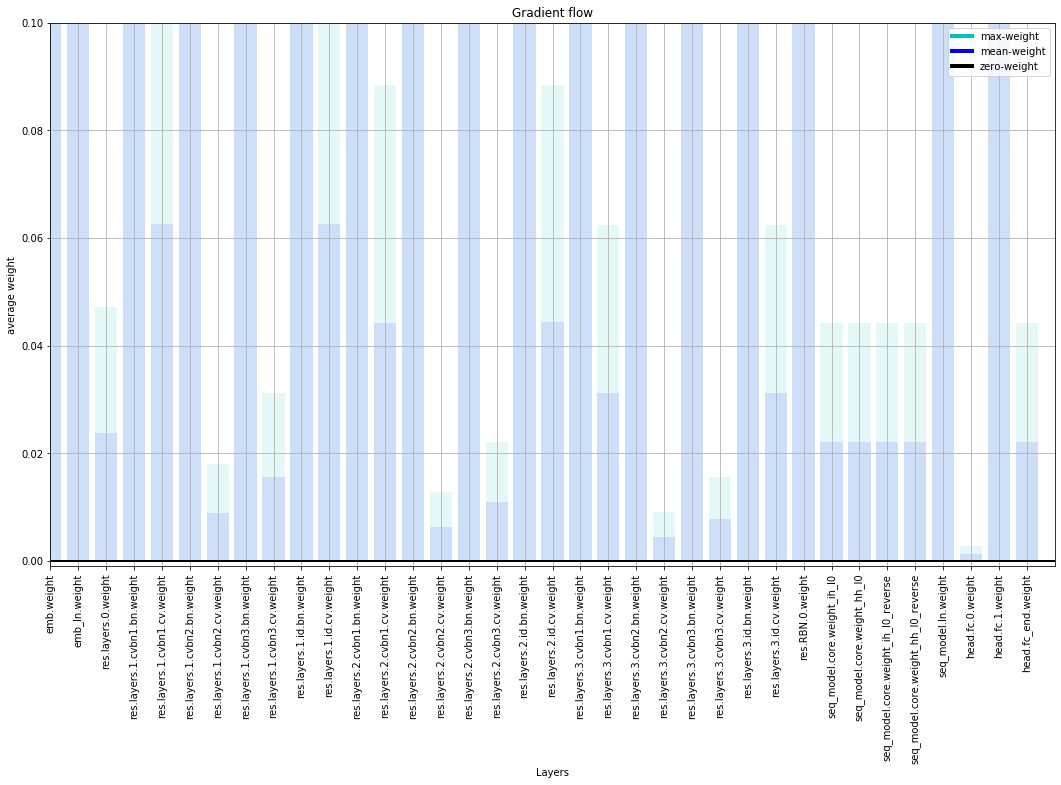

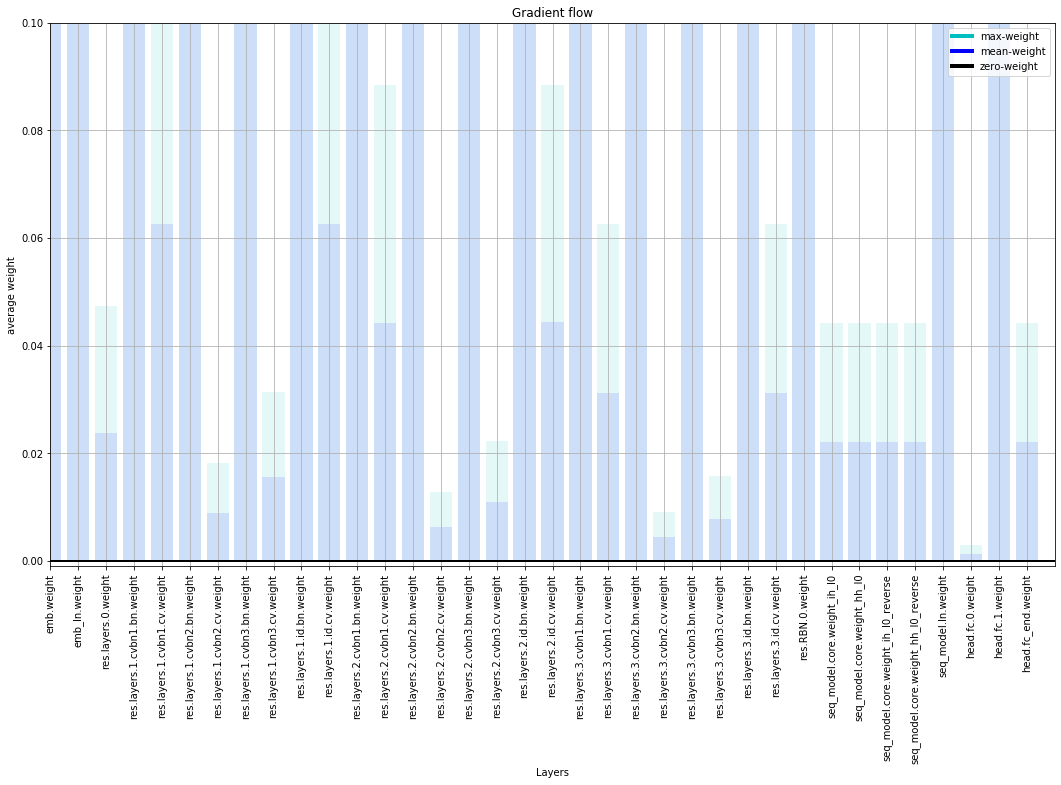

In [14]:
# loss_fn = nn.BCEWithLogitsLoss()
# op = torch.optim.Adam(model.parameters(), lr=1e-4,betas=(0.5,0.999))
# # plt.figure(figsize=(20,15))
# for i,(x,y) in enumerate(exp.val_dataloader()[0]):
#     op.zero_grad()
#     x,y = x.cuda(),  y.cuda()
#     y_hat, mem = model(x)
#     loss = loss_fn(y_hat, y)
#     loss.backward()
# #     fig = plot_grad_flow(model.named_parameters())
#     fig = plot_weight_mag(model.named_parameters(),bottom = -0.001, top=1.5)
#     op.step()
#     if i==1:break

## Validation

In [12]:
trainer.test(exp)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Loading training dataset


Testing: 100%|██████████| 18201/18201 [03:42<00:00, 81.95batch/s]

Test ROC AUC: 0.895789623260498 Test PR AUC: 0.43330907821655273


In [ ]:
#TODO

# https://arxiv.org/pdf/1912.01857.pdf
# https://github.com/feidfoe/AdjustBnd4Imbalance/blob/master/cifar.py
gamma = 0.1 # hparams for re_scaling https://arxiv.org/pdf/1912.01857.pdf
if args.evaluate:
    print('\nEvaluation only')
    test_loss, test_acc = test(testloader, model, criterion, 
                               start_epoch, use_cuda)
    print('[w/o RS] Test Loss: %.8f, Test Acc: %.2f%%' % (test_loss, test_acc))

    current_state = model.state_dict()
    W = current_state['module.fc.weight']

    imb_factor = 1. / args.imbalance
    img_max = 50000/num_classes
    num_sample = [img_max * (imb_factor**(i/(num_classes - 1))) \
                     for i in range(num_classes)]

    ns = [ float(n) / max(num_sample) for n in num_sample ]
    ns = [ n**gamma for n in ns ]
    ns = torch.FloatTensor(ns).unsqueeze(-1).cuda()
    new_W = W / ns

    current_state['module.fc.weight'] = new_W
    model.load_state_dict(current_state)

    test_loss, test_acc = test(testloader, model, criterion, 
                               start_epoch, use_cuda)
    print('[w/  RS] Test Loss: %.8f, Test Acc: %.2f%%' % (test_loss, test_acc))